# Importing Libraries

In [1]:
import ase.io # for reading *.xyz
import pandas as pd # for dataframes
import itertools
from IPython.display import clear_output

import matplotlib.pyplot as plt # for plotting error distribution
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)

from bokeh.plotting import figure, output_notebook
from bokeh.io import show
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)

# Setting Variables and Functions

In [2]:
DATASET_LOCATION = "../data_structures_errors.xyz" # should be in the same directory as the repository
FIGURE_SIZE_X = 20
FIGURE_SIZE_Y = FIGURE_SIZE_X/2

In [3]:
def plot_element(element_df, error):
    plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
    plt.xlabel('Element')
    plt.ylabel(error)
    plt.bar(element_df["symbol"],
            element_df[error],
            color=[(1, 0, 0, 1) if element_df.loc[element, "symbol"] == "O"
                    else (0.8, 0, 1, element_df.loc[element, "frequency"]/element_df.loc[0, "frequency"]) if element_df.loc[element, "symbol"] == "C" or element_df.loc[element, "symbol"] == "N" or element_df.loc[element, "symbol"] == "H"
                    else (31/255, 119/255, 180/255, element_df.loc[element, "frequency"]/element_df.loc[9, "frequency"])  
                    for element in element_df.index])
    plt.show()

def ptable_plotter( # adapted from https://github.com/arosen93/ptable_trends
    data_elements,
    data_list,
    width=1050,
    cmap="plasma",
    alpha=0.65,
    log_scale=False,
    cbar_height=None,
    cbar_standoff=12,
    cbar_fontsize=14,
    blank_color="#c4c4c4",
    under_value=None,
    under_color="#140F0E",
    over_value=None,
    over_color="#140F0E",
    special_elements=None,
    special_color="#6F3023",
) -> figure: 

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        pass

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    period_label.append("blank")

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data_list:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data_list), high=max(data_list)
        )
        norm = LogNorm(vmin=min(data_list), vmax=max(data_list))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data_list), high=max(data_list)
        )
        norm = Normalize(vmin=min(data_list), vmax=max(data_list))
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data_list, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            pass
        if under_value is not None and data_list[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data_list[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.width = width
    p.outline_line_color = None
    p.background_fill_color = "#FFFFFF"
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    output_notebook(hide_banner=True)
    show(p)

# Reading and Importing Dataset

In [4]:
dataset_list = list(ase.io.iread(filename=DATASET_LOCATION, format="extxyz")) # reading *.xyz file as a generator, then converting into list
df = pd.DataFrame(dataset_list)

In [58]:
df["number of atoms"] = [len(dataset_list[i]) for i in range(len(dataset_list))]
df["chemical formula list"] = [tuple([dataset_list[i][element].symbol for element in range(len(dataset_list[i]))]) for i in range(len(dataset_list))]
df["chemical formula"] = [dataset_list[i].get_chemical_formula() for i in range(len(dataset_list))]

df["Lattice (unit cell with three vectors)"] = [tuple(dataset_list[i].get_cell()[:]) for i in range(len(dataset_list))]
df["volume of unit cell (derived from Lattice)"] = [dataset_list[i].get_cell().volume for i in range(len(dataset_list))]

df["energy (error)"] = [dataset_list[i].info["energy"] for i in range(len(dataset_list))]
# Properties part not impt; pbc is "T T T" for all

display(df.head())
print(df.shape)

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,number of atoms,chemical formula list,chemical formula,Lattice (unit cell with three vectors),volume of unit cell (derived from Lattice),energy (error)
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,None,None,86,"(Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...",HAl60NRh24,"([11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
1,"Atom('Zr', [5.31270552, 11.38425636, 12.790607...","Atom('Zr', [5.31270552, 4.67047501, 12.7906074...","Atom('Zr', [2.12508202, 4.67047501, 10.9502325...","Atom('Zr', [8.50032902, 11.38425636, 10.950232...","Atom('Zr', [7.43778753, 8.75708675, 12.7906074...","Atom('Zr', [1.06254113, 2.04330564, 12.7906074...","Atom('Zr', [4.25016451, 2.04330564, 10.9502315...","Atom('Zr', [4.25016451, 8.75708675, 10.9502315...","Atom('Zr', [5.31270552, 11.38425636, 16.471357...","Atom('Zr', [5.31270552, 4.67047501, 16.4713573...",...,None,None,None,None,85,"(Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Z...",C2HN32O2Se16Zr32,"([12.750493049621582, 0.0, 0.0], [3.1876232624...",5041.392243,-1.486445
2,"Atom('Ag', [1.99755764, 0.0, 12.556077], index=0)","Atom('Ag', [1.99755764, 0.0, 16.55119133], ind...","Atom('Ag', [1.99755764, 0.0, 20.54630661], ind...","Atom('Ag', [5.99267292, 0.0, 12.556077], index=3)","Atom('Ag', [5.99267292, 0.0, 16.55119133], ind...","Atom('Ag', [5.99267292, 0.0, 20.54630661], ind...","Atom('Ag', [9.9877882, 0.0, 12.556077], index=6)","Atom('Ag', [9.9877882, 0.0, 16.55119133], inde...","Atom('Ag', [9.9877882, 0.0, 20.54630661], inde...","Atom('P', [0.0, 3.52585888, 10.55851936], inde...",...,None,None,None,None,66,"(Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, P, P, P, ...",H2Ag9OP9Pd45,"([11.985345840454102, 0.0, 0.0], [0.0, 7.05171...",3038.906189,0.198341
3,"Atom('Hf', [9.38242626, 12.50322628, 14.585413...","Atom('Hf', [6.35710812, 3.12580657, 18.5775795...","Atom('Hf', [7.86976767, 7.81451654, 21.8971786...","Atom('Hf', [6.96020222, 13.28467846, 19.901096...","Atom('Hf', [3.93488359, 3.90725827, 23.8932628...","Atom('Hf', [5.44754267, 8.59596825, 16.5814971...","Atom('Hf', [6.20387268, 10.94032288, 18.241296...","Atom('Hf', [3.17855406, 1.56290329, 22.2334613...","Atom('Hf', [4.69121313, 6.25161314, 14.9216957...","Atom('Hf', [5.60077858, 0.7814517, 16.91777992...",...,None,None,None,None,62,"(Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, H...",C2H5Hf30OSn24,"([8.023002624511719, 0.0, -3.6558828353881836]...",4799.108881,-5.876447
4,"Atom('Tc', [5.52350187, 3.18899536, 15.7963838...","Atom('Tc', [8.28525257, 7.9724884, 20.15400696...","Atom('Tc', [2.76175094, 1.59449768, 17.9751968...","Atom('Tc', [5.52350187, 6.37799072, 17.9751968...","Atom('Tc', [5.52350187, 3.18899536, 20.1540069...","Atom('Tc', [8.28525257, 7.9724884, 24.51163101...","Atom('Tc', [2.76175094, 1.59449768, 22.3328189...","Atom('Tc', [5.52350187, 6.37799072, 22.3328189...","Atom('Tc', [11.04700375, 3.18899536, 15.796383...","Atom('Tc', [13.80875492, 7.9724884, 20.1540069...",...,None,None,None,None,67,"(Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, T...",CH2Os48Tc16,"([11.047003746032715, 0.0, 0.0], [5.5235018730...",3684.336555,-2.103216


(460333, 231)


# Distribution of Error when Sorted by Volume of Unit Cell

Scatter plot

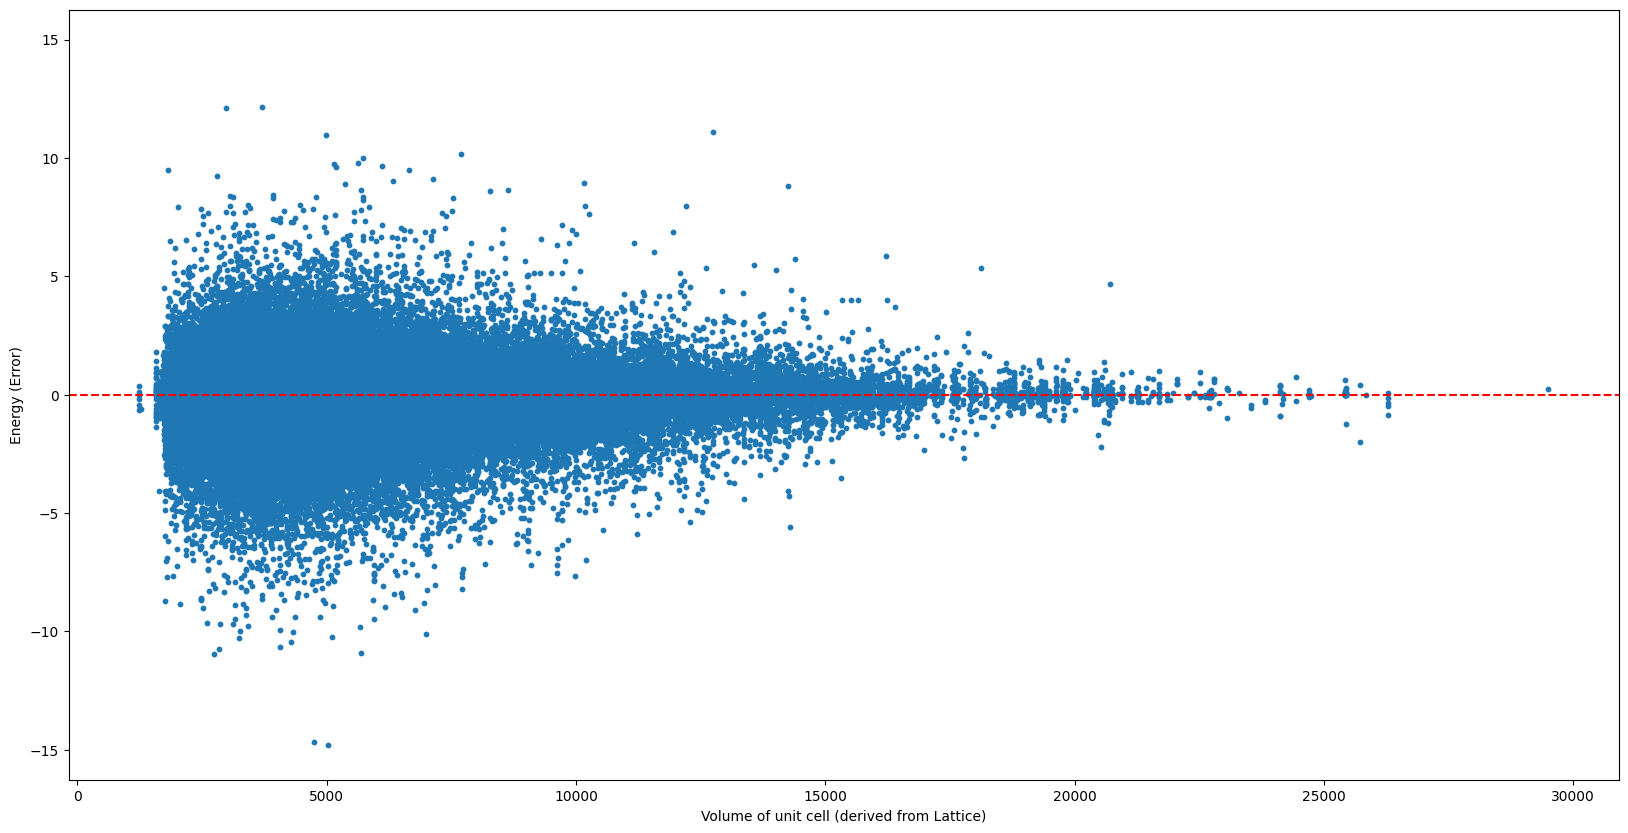

In [6]:
df_volume_sorted = df.sort_values(by=["volume of unit cell (derived from Lattice)"])
plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.xlabel("Volume of unit cell (derived from Lattice)")
plt.ylabel("Energy (Error)")
plt.ylim(-1.1*df["energy (error)"].abs().max(), 1.1*df["energy (error)"].abs().max())
plt.scatter(df_volume_sorted["volume of unit cell (derived from Lattice)"], df_volume_sorted['energy (error)'], s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Moving average

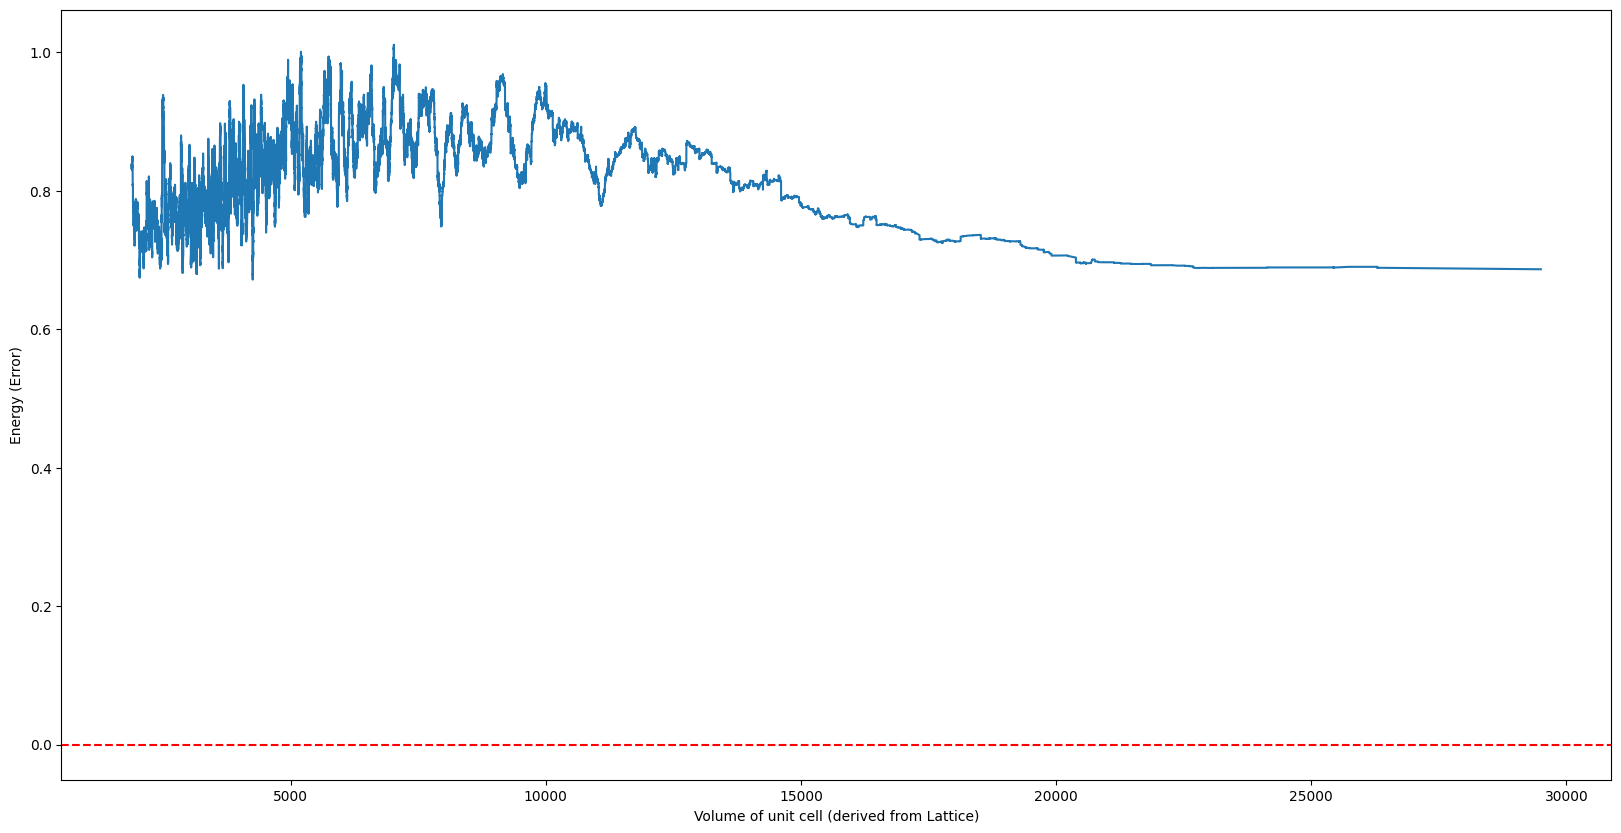

In [7]:
plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.xlabel("Volume of unit cell (derived from Lattice)")
plt.ylabel("Energy (Error)")
#plt.ylim(-0.5*df["energy (error)"].abs().max(), 0.5*df["energy (error)"].abs().max())
plt.plot(df_volume_sorted["volume of unit cell (derived from Lattice)"], df_volume_sorted['energy (error)'].rolling(3000).std()) # by data points
# .abs(), .mean(), .median()
# by fraction of length of x-axis
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Distribution of Error (abs) when Sorted by Element Present (Weighted and Unweighted by number of atoms)

In [8]:
#extract list of elements
#element_list = []
#for i in range(len(df)):
#    element_list += dataset_list[i].get_chemical_symbols()
#    element_list = [*set(element_list)]

element_list = ['H',
                                                                                                'B', 'C', 'N', 'O',
                'Na',                                                                           'Al', 'Si', 'P', 'S', 'Cl',
                'K', 'Ca',      'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',      'Ga', 'Ge', 'As', 'Se',
                'Rb', 'Sr',     'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',      'In', 'Sn', 'Sb', 'Te', 
                'Cs',           'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',            'Tl', 'Pb', 'Bi']

element_df = pd.DataFrame(data={"symbol":element_list, "frequency":0, "unweighted_mean_errors":0, "unweighted_mean_abs_errors":0, "weighted_mean_errors":0, "weighted_mean_abs_errors":0})

for element in element_df.index:    
    display(element_df,clear=True)
    df_filtered = df[df['chemical formula'].str.contains(element_df.loc[element, "symbol"])].reset_index(drop=True)

    element_df.loc[element, "frequency"] = len(df_filtered)

    element_df.loc[element, "unweighted_mean_errors"] = df_filtered["energy (error)"].mean()
    element_df.loc[element, "unweighted_mean_abs_errors"] = df_filtered["energy (error)"].abs().mean()

    for i in range(len(df_filtered)):
        number_of_element_atom = df_filtered.loc[i, 'chemical formula list'].count(element_df.loc[element, "symbol"])

        weight = number_of_element_atom/df_filtered.loc[i, "number of atoms"]
        #weighted_errors.append(df_filtered["energy (error)"].abs()[i] * weight) # absolute value is used
        element_df.loc[element, "weighted_mean_errors"] += df_filtered.loc[i, "energy (error)"] * weight / len(df_filtered)
        element_df.loc[element, "weighted_mean_abs_errors"] += abs(df_filtered.loc[i, "energy (error)"]) * weight / len(df_filtered)

display(element_df,clear=True)        

,symbol,frequency,unweighted_mean_errors,unweighted_mean_abs_errors,weighted_mean_errors,weighted_mean_abs_errors
0,H,378922,-0.019817,0.461235,-0.001600,0.025864
1,B,10024,-0.024642,0.419941,-0.002586,0.014507
2,C,348795,-0.014919,0.461594,-0.000207,0.015359
3,N,178590,-0.031265,0.573317,-0.001679,0.044604
4,O,310952,-0.026288,0.519804,-0.000412,0.010501
5,Na,13223,0.003414,0.402491,0.003092,0.139262
6,Al,40268,-0.020268,0.477242,-0.010110,0.201377
7,Si,37767,-0.022944,0.526298,-0.009084,0.207116
8,P,87122,-0.015475,0.420963,-0.003881,0.077501
9,S,173261,-0.021183,0.541052,-0.002454,0.085391


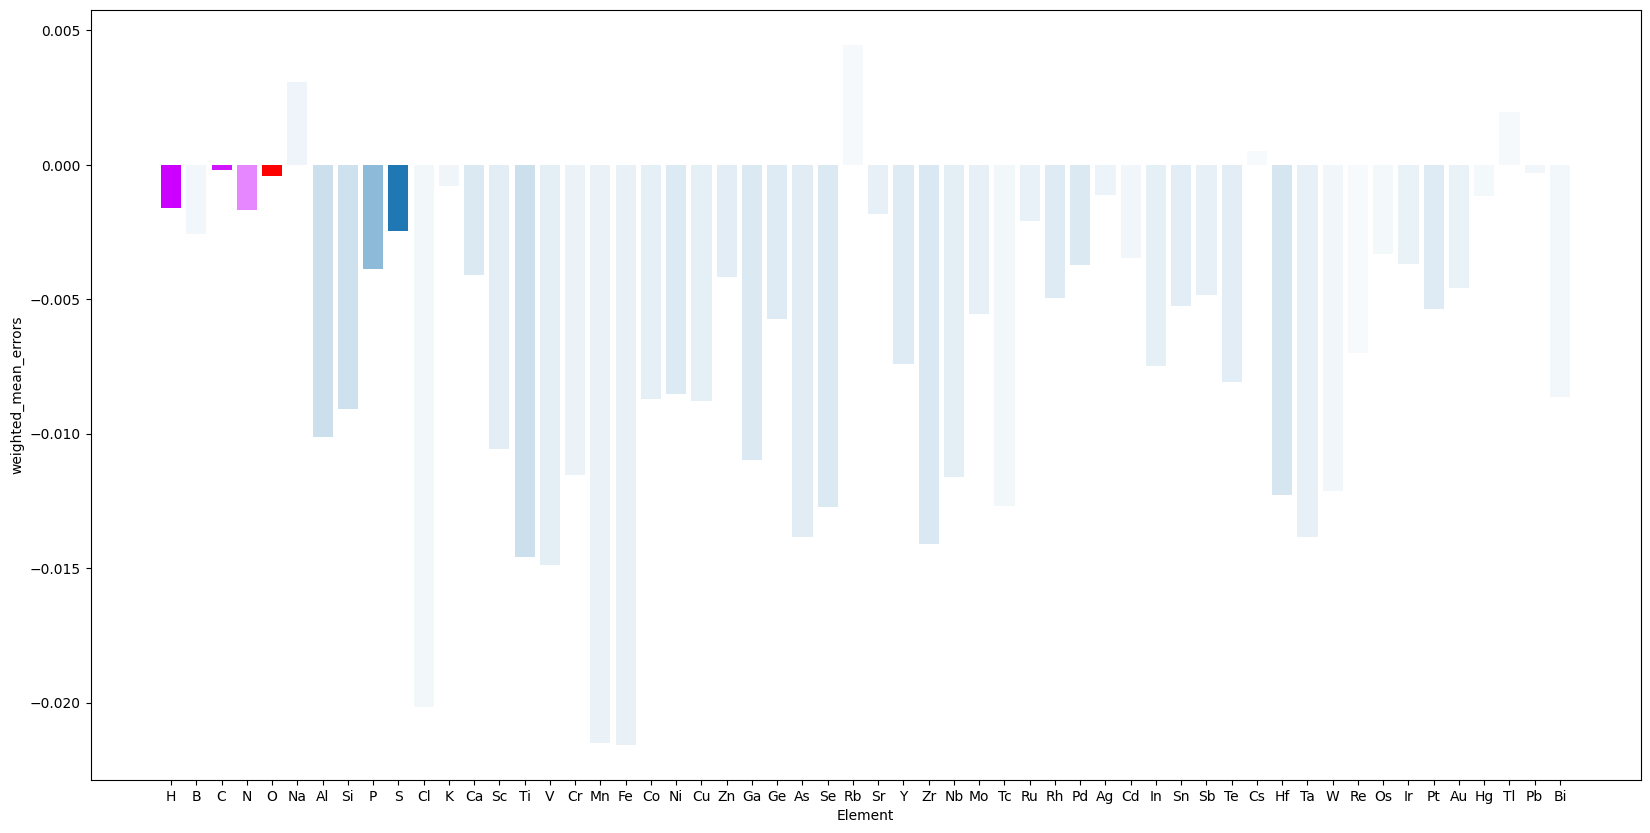

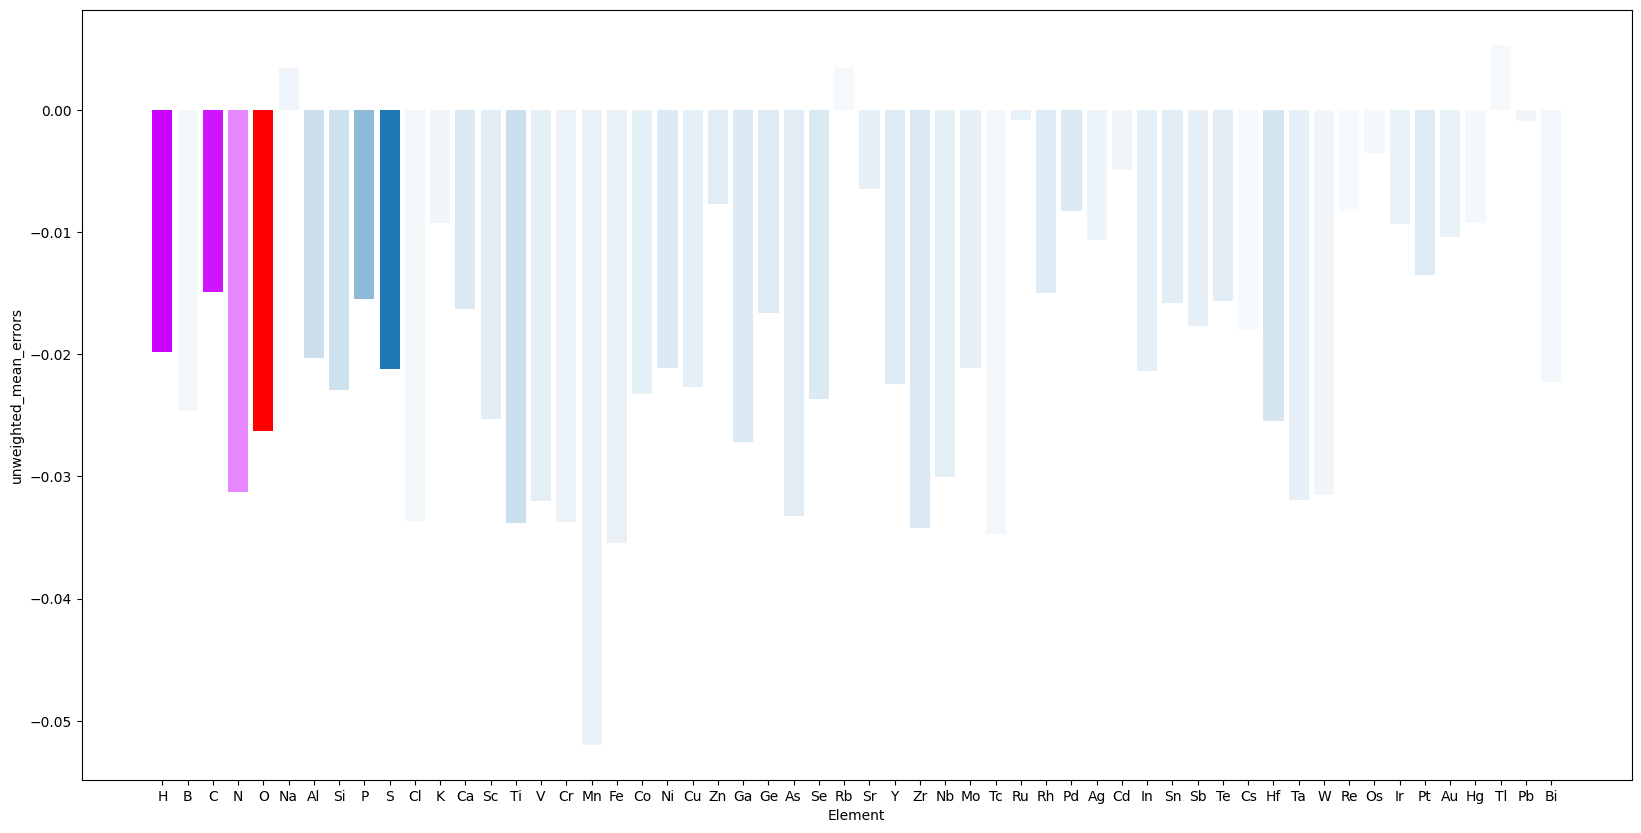

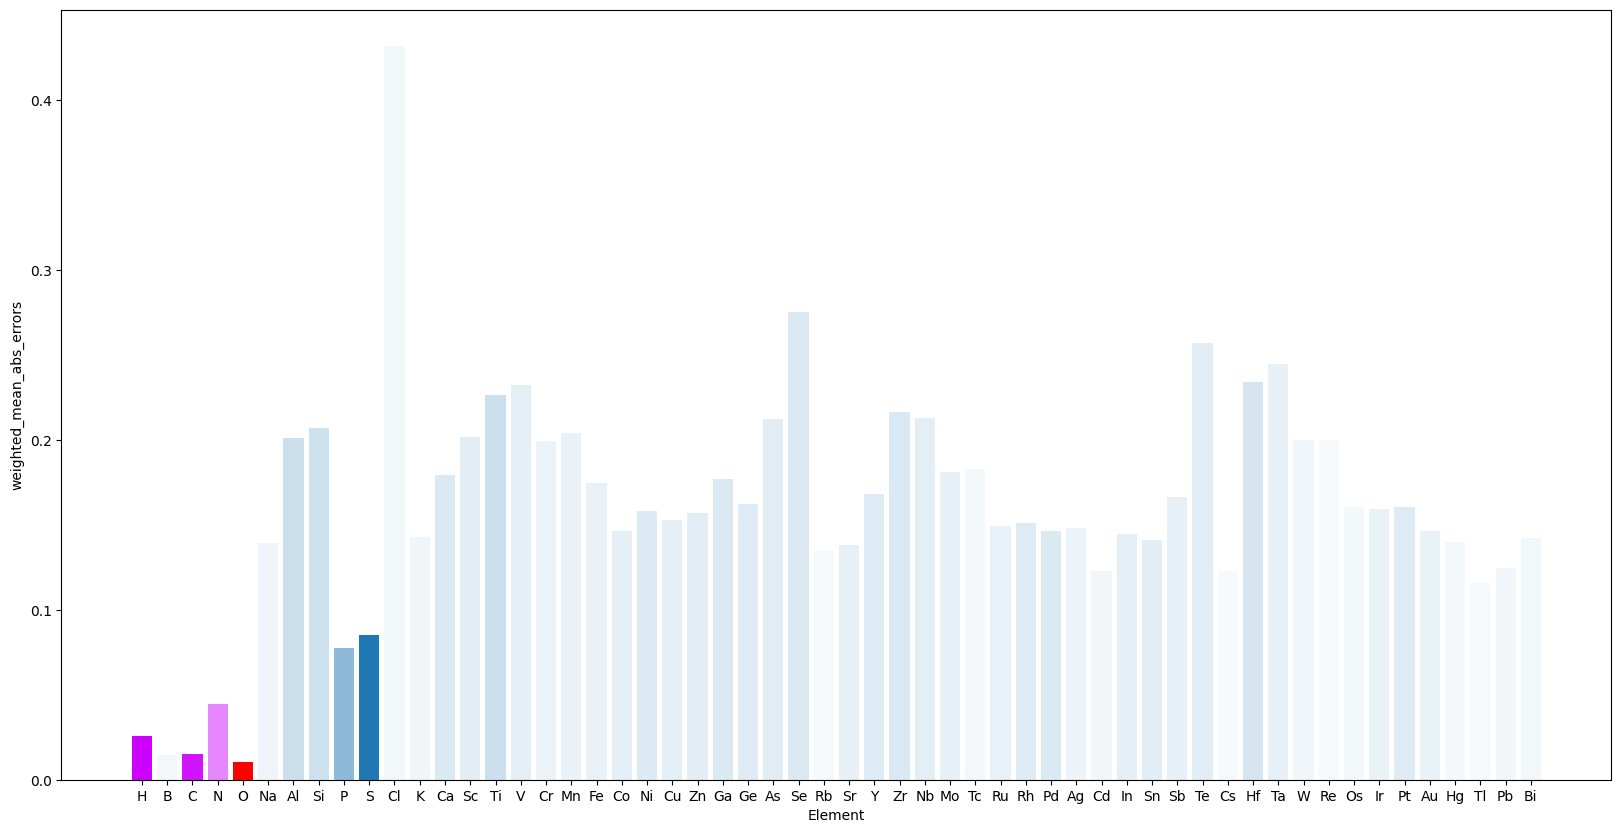

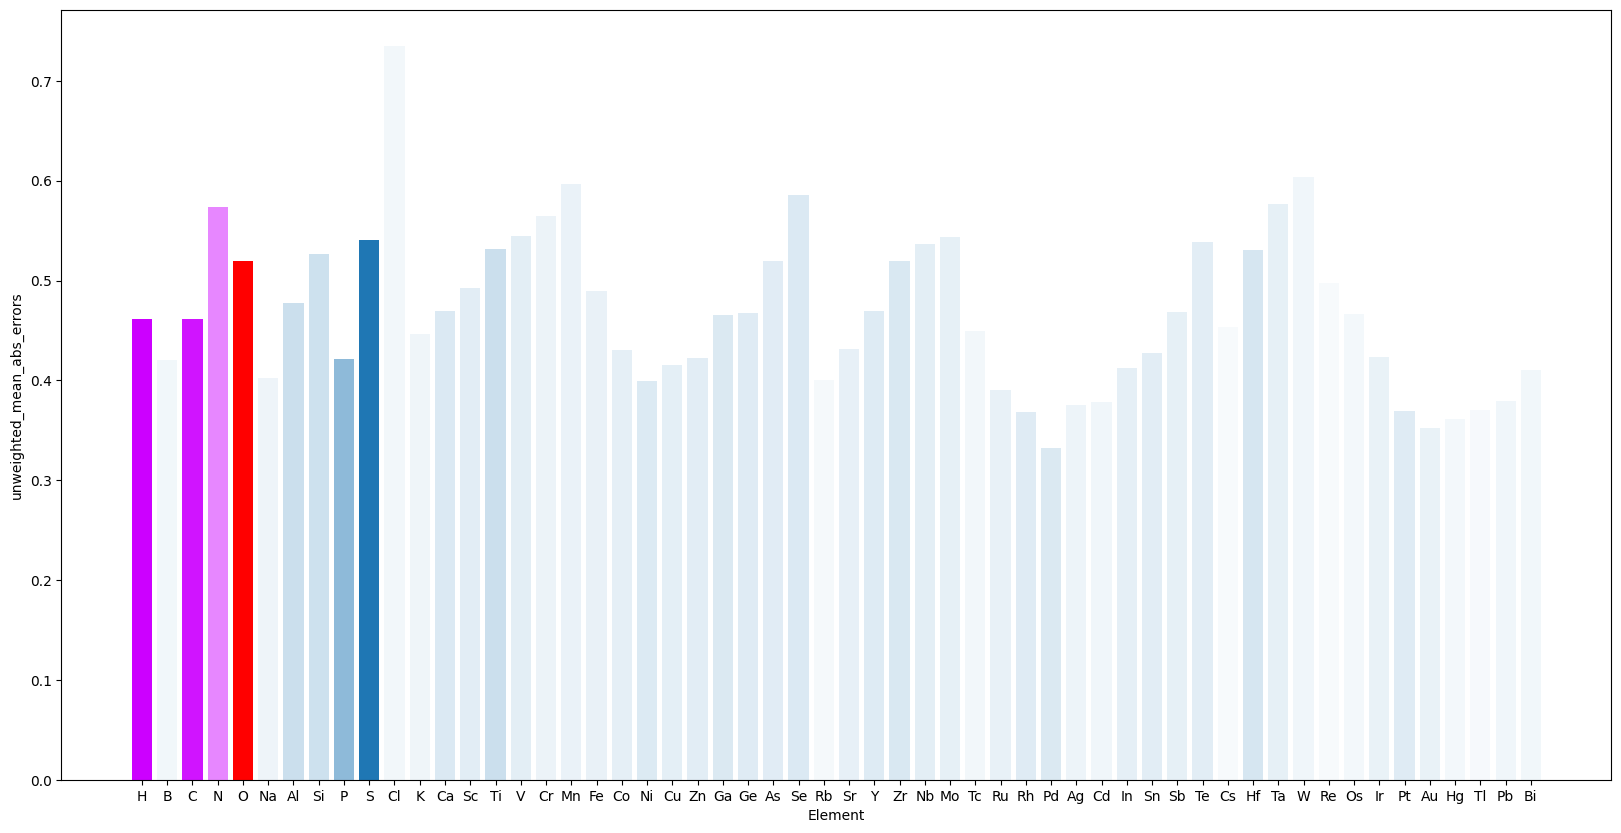

In [9]:
plot_element(element_df, "weighted_mean_errors")
plot_element(element_df, "unweighted_mean_errors")
plot_element(element_df, "weighted_mean_abs_errors")
plot_element(element_df, "unweighted_mean_abs_errors")

In [10]:
ptable_plotter(element_df["symbol"], element_df["unweighted_mean_errors"])
ptable_plotter(element_df["symbol"], element_df["weighted_mean_errors"])
ptable_plotter(element_df["symbol"], element_df["unweighted_mean_abs_errors"])
ptable_plotter(element_df["symbol"], element_df["weighted_mean_abs_errors"])

# Distribution of Error (abs) when Sorted by adsorbate Present

An attempt to scan for the adsorbate

In [11]:
# LOOKS LIKE O WAS THE NON-CATALYST ELEMENT, NOT H
# adsorbate_list = []
# for i in range(len(df)):
#         adsorbate = []
#         elements_tail_12 = df.loc[i, "chemical formula list"][-12:]
#         for element in elements_tail_12:
#                 if element == "H" or element == "O" or element == "N" or element == "C":
#                         adsorbate.append(element)
#         adsorbate_list.append(adsorbate)     

# adsorbate_list = [adsorbate for adsorbate in adsorbate_list if adsorbate.count("C") <= 2 and adsorbate.count("N") <= 3 and adsorbate.count("H") <= 8]

# adsorbate_list.sort()
# adsorbate_list = list(adsorbate_list for adsorbate_list,_ in itertools.groupby(adsorbate_list))
# adsorbate_list.remove([])
# print(len(adsorbate_list))
# print(adsorbate_list)

In [69]:
# painfully added manually :(
adsorbate_list = [['H'], ['O'], ['O', 'H'], ['H', 'H', 'O'],

                  ['C'], ['C', 'O'], ['H', 'C'], ['C', 'H', 'O'], ['C', 'H', 'H'], ['C', 'H', 'H', 'O'],
                  ['C', 'H', 'H', 'H'], ['C', 'H', 'H', 'H', 'O'], ['H', 'H', 'H', 'H', 'C'], ['C', 'H', 'H', 'H', 'H', 'O'], 

                  ['C', 'C'], ['C', 'C', 'O'], ['C', 'C', 'H'], ['H', 'C', 'C', 'O'], ['C', 'C', 'H', 'O', 'O'],
                  ['C', 'C', 'H', 'H', 'O'], ['C', 'C', 'H', 'H'], ['C', 'C', 'H', 'H', 'O'],
                  ['C', 'C', 'H', 'H', 'O', 'O'],
                  ['C', 'C', 'H', 'H', 'H'], ['C', 'C', 'H', 'H', 'H', 'O'],
                  ['C', 'C', 'H', 'H', 'H', 'O', 'O'],
                  ['H', 'H', 'H', 'H', 'C', 'C'], ['C', 'C', 'H', 'H', 'H', 'H', 'O'],
                  ['C', 'C', 'H', 'H', 'H', 'H', 'O', 'O'],
                  ['H', 'H', 'H', 'H', 'H', 'C', 'C'],
                  ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'O'], ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'O', 'O'],
                  ['H', 'H', 'H', 'H', 'H', 'H', 'C', 'C', 'O'], 

                  ['N', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], ['N', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'O'], ['N', 'N', 'O', 'H', 'H', 'H', 'H', 'C'], ['N', 'N', 'C', 'H', 'H', 'H'], ['O', 'N', 'H'],
                  ['N', 'N', 'H', 'H'], ['N', 'N', 'N', 'H'], ['N', 'N', 'H'], ['N', 'N', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'N', 'N'], ['N', 'N', 'O'],
                  ['N', 'N'], ['N', 'N', 'H', 'H', 'O'], ['N', 'H', 'H'], ['N', 'H', 'H', 'H'], ['N', 'N', 'H', 'O'], ['N', 'H'], ['N', 'O', 'O'], ['N', 'O'], ['N'],
                  ['N', 'O', 'O', 'O'], ['N', 'H', 'H', 'H', 'O'], ['N', 'H', 'O', 'O'], ['C', 'N']]

adsorbate_df = pd.DataFrame(data={"formula list":[tuple(i) for i in adsorbate_list], "len":[len(adsorbate) for adsorbate in adsorbate_list], "frequency":0, "mean_errors":0, "mean_abs_errors":0})
adsorbate_df = adsorbate_df.sort_values('len', ascending=False)

df_filtered = df
for adsorbate in adsorbate_df.index:
    display(adsorbate_df,clear=True)
    print(len(df_filtered))
    df_filtered = df_filtered[pd.Series(df_filtered.loc[i, "chemical formula list"][-len(adsorbate_df.loc[adsorbate, "formula list"]):] ==
                     adsorbate_df.loc[adsorbate, "formula list"]
                     for i in range(len(df_filtered)))].reset_index(drop=True)
                
    adsorbate_df.loc[adsorbate, "frequency"] = len(df_filtered)
    adsorbate_df.loc[adsorbate, "mean_errors"] = df_filtered["energy (error)"].mean()
    adsorbate_df.loc[adsorbate, "mean_abs_errors"] = df_filtered["energy (error)"].abs().mean()


    df_filtered = pd.merge(df, df_filtered, indicator=True, how='outer', on='chemical formula').query('_merge=="left_only"').drop('_merge', axis=1).reset_index(drop=True)
    # df_filtered = df.drop(df_filtered.index, axis="index")

adsorbate_df = adsorbate_df.sort_index()
display(adsorbate_df,clear=True)        

,formula list,len,frequency,mean_errors,mean_abs_errors
33,"(N, N, C, C, H, H, H, H, H, H, H, H)",12,0,NaN,NaN
34,"(N, N, C, C, H, H, H, H, H, H, O)",11,0,0.0,0.0
32,"(H, H, H, H, H, H, C, C, O)",9,0,0.0,0.0
31,"(C, C, H, H, H, H, H, O, O)",9,0,0.0,0.0
35,"(N, N, O, H, H, H, H, C)",8,0,0.0,0.0
30,"(C, C, H, H, H, H, H, O)",8,0,0.0,0.0
28,"(C, C, H, H, H, H, O, O)",8,0,0.0,0.0
29,"(H, H, H, H, H, C, C)",7,0,0.0,0.0
27,"(C, C, H, H, H, H, O)",7,0,0.0,0.0
25,"(C, C, H, H, H, O, O)",7,0,0.0,0.0


460333


KeyError: 'chemical formula list'

In [67]:
print(adsorbate_df["frequency"].sum(),
      len(df),
      adsorbate_df["frequency"].sum() - len(df))

5507 460333 -454826


,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,number of atoms,chemical formula list,chemical formula,Lattice (unit cell with three vectors),volume of unit cell (derived from Lattice),energy (error)
315139,"Atom('Ag', [3.91874456, 10.52102566, 15.089921...","Atom('Ag', [1.23523724, 6.03490305, 16.0351181...","Atom('Ag', [4.2410903, 3.47140431, 12.40208054...","Atom('Ag', [3.52521777, 8.59840107, 20.0853500...","Atom('Ag', [0.84171033, 4.11227894, 21.0305481...","Atom('Ag', [3.84756351, 1.54878032, 17.3975086...","Atom('Ag', [9.21457863, 10.52102566, 15.507113...","Atom('Ag', [6.53107119, 6.03490305, 16.4523105...","Atom('Ag', [9.53692436, 3.47140431, 12.8192720...","Atom('Ag', [8.8210516, 8.59840107, 20.5025425]...",...,None,None,None,None,74,"(Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, A...",Ag12Al36Hf24N2,"([10.591667175292969, 0.0, 0.8343841433525085]...",3875.052291,-1.023823
457700,"Atom('Hf', [2.68354464, 1.54934525, 24.9593219...","Atom('Hf', [2.68354464, 1.54934525, 21.7850017...","Atom('Hf', [5e-08, 3.09869051, 16.32960129], i...","Atom('Hf', [5e-08, 3.09869051, 13.15528011], i...","Atom('Hf', [0.0, 0.0, 20.64446068], index=4)","Atom('Hf', [0.0, 0.0, 17.47014046], index=5)","Atom('Hf', [-5e-08, 6.19738102, 24.95932198], ...","Atom('Hf', [-5e-08, 6.19738102, 21.78500175], ...","Atom('Hf', [-2.68354464, 7.74672651, 16.329601...","Atom('Hf', [-2.68354464, 7.74672651, 13.155280...",...,None,None,None,None,74,"(Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, H...",Ag12Al36Hf24NO,"([10.73417854309082, 0.0, 0.0], [-5.3670892715...",3875.052204,0.770261
341962,"Atom('Ag', [7.39440441, 8.13355064, 11.6931924...","Atom('Ag', [2.20180249, 4.86061001, 13.6300172...","Atom('Ag', [3.43096399, 1.58766925, 15.9998540...","Atom('Ag', [7.00379324, 6.73086166, 17.4861278...","Atom('Ag', [1.81119132, 3.45792103, 19.4229526...","Atom('Ag', [3.04035282, 0.18498054, 21.7927894...","Atom('Ag', [13.81616783, 8.13355064, 12.126204...","Atom('Ag', [8.62356567, 4.86061001, 14.0630292...","Atom('Ag', [9.85272694, 1.58766925, 16.4328670...","Atom('Ag', [13.42555618, 6.73086166, 17.919139...",...,None,None,None,None,63,"(Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, A...",Ag12Al36NO2Y12,"([12.843526840209961, 0.0, 0.8660248517990112]...",3661.541502,-0.631527
259324,"Atom('Ag', [0.59080482, 2.10170269, 18.9792289...","Atom('Ag', [7.11345768, 6.05784941, 23.8845195...","Atom('Ag', [2.17416787, 7.04688597, 14.9534950...","Atom('Ag', [7.13710785, 4.07977581, 21.4639701...","Atom('Ag', [7.08980751, 8.03592205, 26.3050689...","Atom('Ag', [0.61445498, 0.12362958, 16.5586795...","Atom('Ag', [7.16075802, 2.10170269, 19.0434207...","Atom('Ag', [13.6834116, 6.05784941, 23.9487114...","Atom('Ag', [8.74412155, 7.04688597, 15.0176868...","Atom('Ag', [13.70706081, 4.07977581, 21.528162...",...,None,None,None,None,54,"(Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, A...",Ag12As12K24N2O4,"([13.139906883239746, 0.0, 0.12838433682918549...",4722.087963,0.598169
246519,"Atom('Ag', [6.08612585, 1.8894515, 15.44663525...","Atom('Ag', [3.67604637, 9.29118824, 13.9485597...","Atom('Ag', [4.88108587, 5.59032011, 14.6975975...","Atom('Ag', [6.48780584, 0.65582865, 19.1918239...","Atom('Ag', [4.07772636, 8.05756569, 17.6937484...","Atom('Ag', [5.28276587, 4.35669708, 18.4427852...","Atom('Ag', [13.07001209, 1.8894515, 14.6975975...","Atom('Ag', [10.65993214, 9.29118824, 13.199522...","Atom('Ag', [11.86497211, 5.59032011, 13.948559...","Atom('Ag', [13.47169209, 0.65582865, 18.442785...",...,None,None,None,None,51,"(Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, A...",Ag12As12N2OSe24,"([13.967772483825684, -0.0, -1.498075246810913...",4336.630661,1.563278
